In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import HDBSCAN, KMeans
import igraph as ig

from sklearn.metrics import normalized_mutual_info_score

from karateclub import FeatherGraph, Graph2Vec

import json
from utils.graph_utils import get_all_user_graphs, get_all_sentiment_user_graphs, get_all_twitter_user_graphs

In [2]:
# Seaborn settings
sns.set_theme(style="whitegrid")        # Clean grid for academic style

# General settings
scale = 0.9
plt.rcParams.update({
#   'text.usetex': True,                # Use LaTeX for all text
    'figure.figsize': (6 * scale, 4 * scale),           # Default figure size
    'figure.autolayout': True,          # Tight layout
    'font.family': 'serif',             # Serif font (default for LaTeX)
    'font.size': 10,                    # Font size
    'axes.titlesize': 11,               # Title size
    'axes.labelsize': 10,               # Axis label size
    'legend.fontsize': 8,               # Legend font size
    'xtick.labelsize': 8,               # Tick label size
    'ytick.labelsize': 8,               # Tick label size
    'figure.dpi': 300,                  # High resolution
    'savefig.dpi': 300,                 # Save figures with high resolution
    'savefig.format': 'pgf',            # Default save format
    #'axes.linewidth': 0.75,             # Line width for axes
    #'legend.frameon': True,             # Remove legend frame
    #'legend.framealpha': 1,             # Legend opacity
})


In [3]:
graphs = get_all_sentiment_user_graphs()
graphs = [g.components(mode='weak').giant() for g in graphs]
mean_sentiment = [np.mean([es['stitcher_score'] for es in g.es if es['stitcher_sentiment_value'] != 3]) for g in graphs]
graphs_nx = [g.simplify().to_networkx() for g in graphs]

categories = [g['category'] for g in graphs]
names = [g['name'] for g in graphs]

/home/mahf/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mahf/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Graph2Vec

In [4]:
model = Graph2Vec(workers=1, seed=42)
model.fit(graphs_nx)
g2v_embs = model.get_embedding()
pca = PCA(n_components=2)
g2v_embs_pca = pca.fit_transform(g2v_embs)
g2v_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(g2v_embs)
print(pca.explained_variance_ratio_)

/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[0.868281   0.09117673]


In [5]:
hdbscan = HDBSCAN()
hdbscan.fit(g2v_embs)
g2v_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, g2v_labels) if label != -1], 
    [label for label in g2v_labels if label != -1])
num_no_cluster = len([label for label in g2v_labels if label == -1])
print(nmi, num_no_cluster)

0.05392654131978827 12


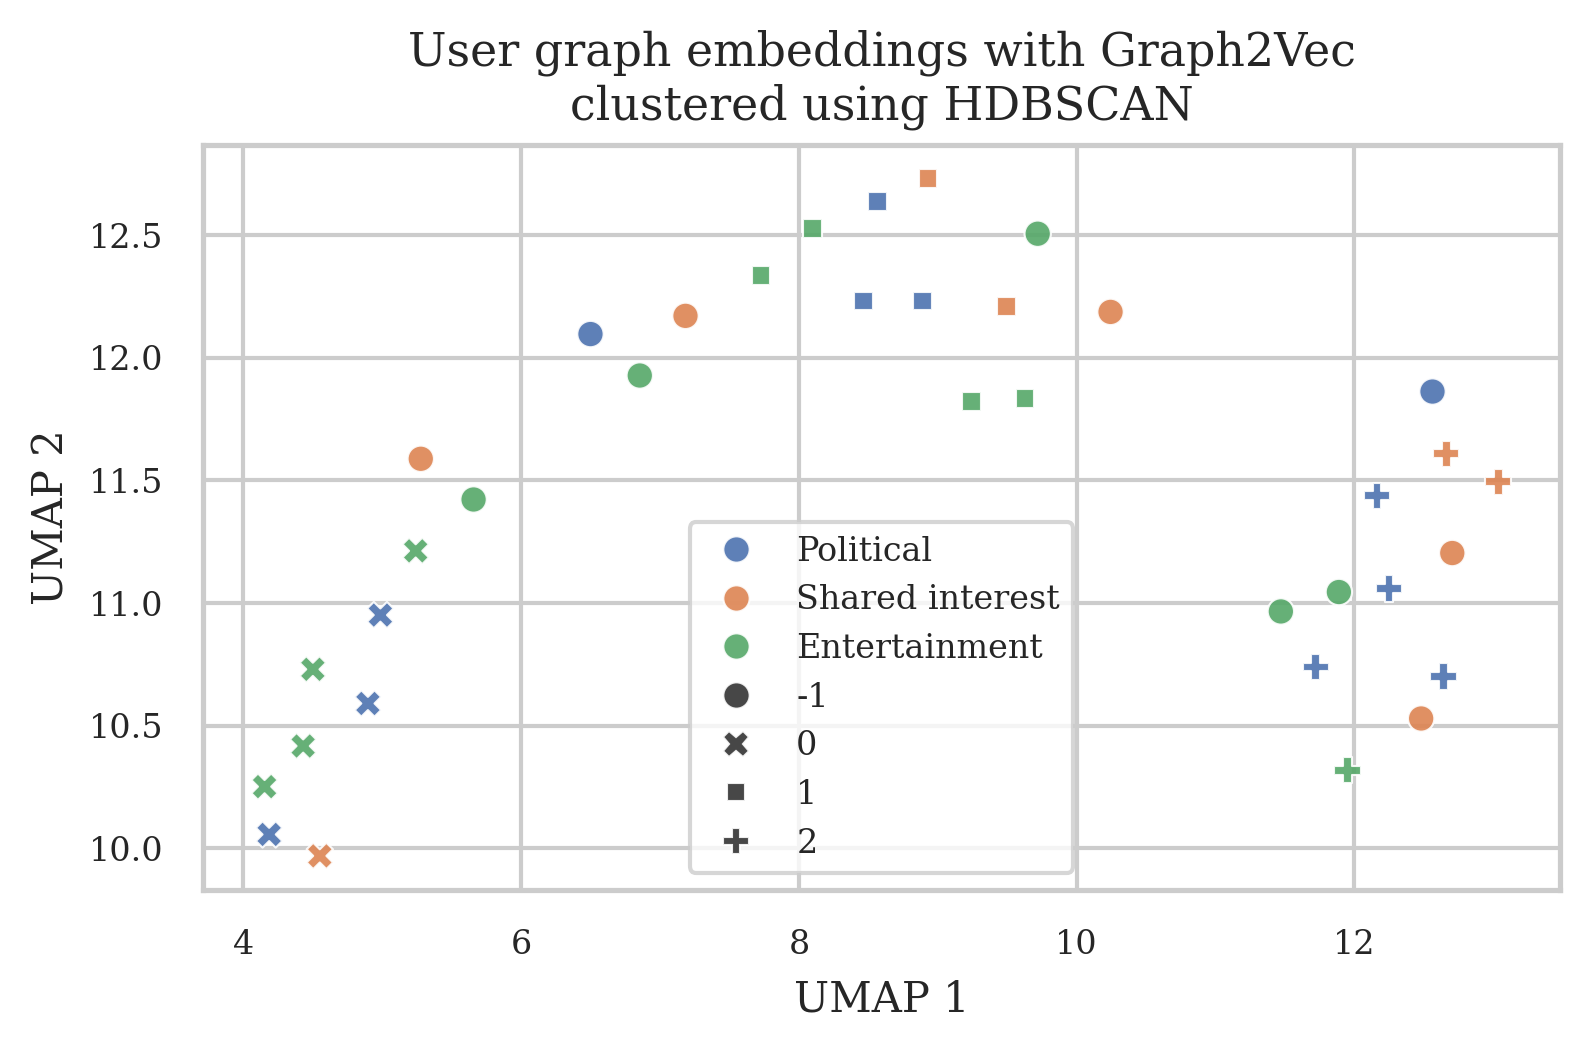

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, style=g2v_labels, s=40, alpha=0.9, ax=ax)
ax.set_title('User graph embeddings with Graph2Vec\nclustered using HDBSCAN')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/graph2vec.pgf', format='pgf', bbox_inches='tight')

### Bag-Of-Subgraphs

In [7]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/lcc.json'))

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
m_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
m_embs_pca = pca.fit_transform(m_embs)
m_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(m_embs)
print(pca.explained_variance_ratio_)

[0.78926539 0.07326133]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
hdbscan = HDBSCAN()
hdbscan.fit(m_embs)
m_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, m_labels) if label != -1], 
    [label for label in m_labels if label != -1])
num_no_cluster = len([label for label in m_labels if label == -1])
print(nmi, num_no_cluster)

0.0008139742996185118 1


In [9]:
vcounts = [g.vcount() for g in graphs]
for label in set(m_labels):
    vcs = [vcount for vcount, l in zip(vcounts, m_labels) if l == label]
    print(label, np.mean(vcs), np.std(vcs), vcs)

0 18.846153846153847 23.114584652739037 [6, 6, 4, 11, 13, 2, 2, 68, 14, 73, 8, 30, 8]
1 280.09090909090907 397.28303502333875 [646, 63, 64, 844, 142, 35, 1838, 73, 243, 109, 74, 141, 344, 79, 365, 414, 71, 144, 11, 173, 272, 17]
-1 11.0 0.0 [11]


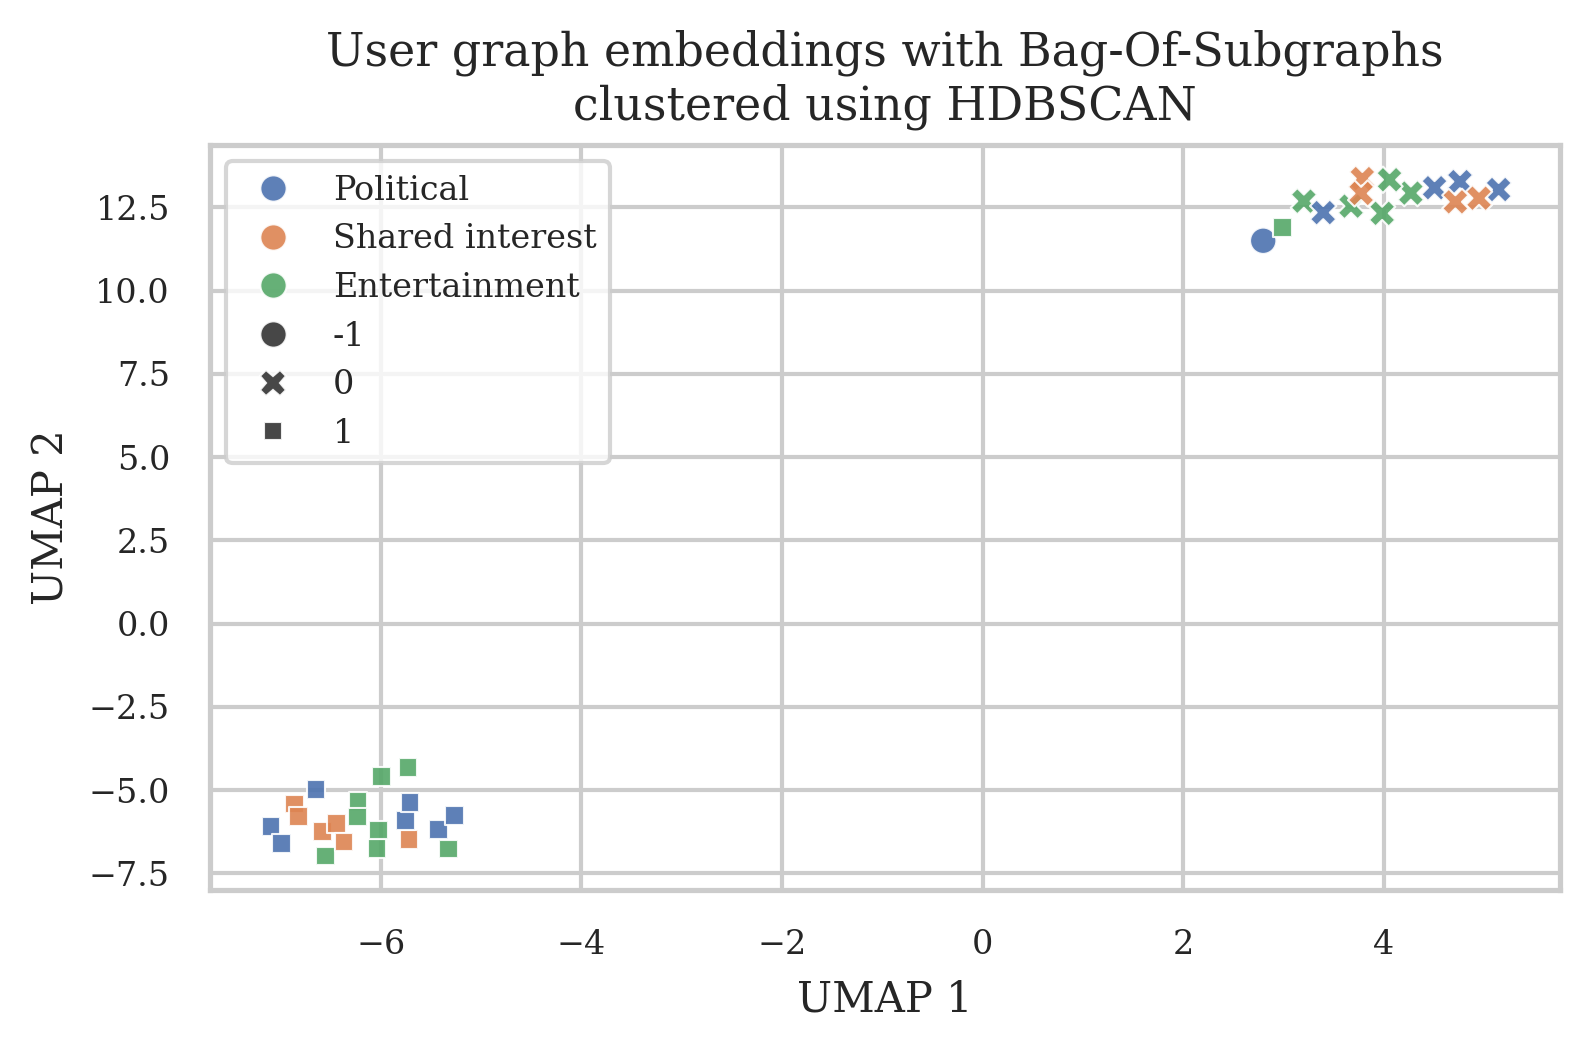

In [10]:
fig, ax = plt.subplots()
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, style=m_labels, s=40, alpha=0.9, ax=ax)
ax.set_title('User graph embeddings with Bag-Of-Subgraphs\nclustered using HDBSCAN')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/subgraph.pgf', format='pgf', bbox_inches='tight')

### Directed Bag-Of-Subgraphs

In [11]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/lcc_directed.json'))

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
dm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
dm_embs_pca = pca.fit_transform(dm_embs)
dm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(dm_embs)
print(pca.explained_variance_ratio_)

[0.63086887 0.12634118]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
hdbscan = HDBSCAN()
hdbscan.fit(dm_embs)
dm_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, dm_labels) if label != -1], 
    [label for label in dm_labels if label != -1])
num_no_cluster = len([label for label in dm_labels if label == -1])
print(nmi, num_no_cluster)

0.022739237565347677 2


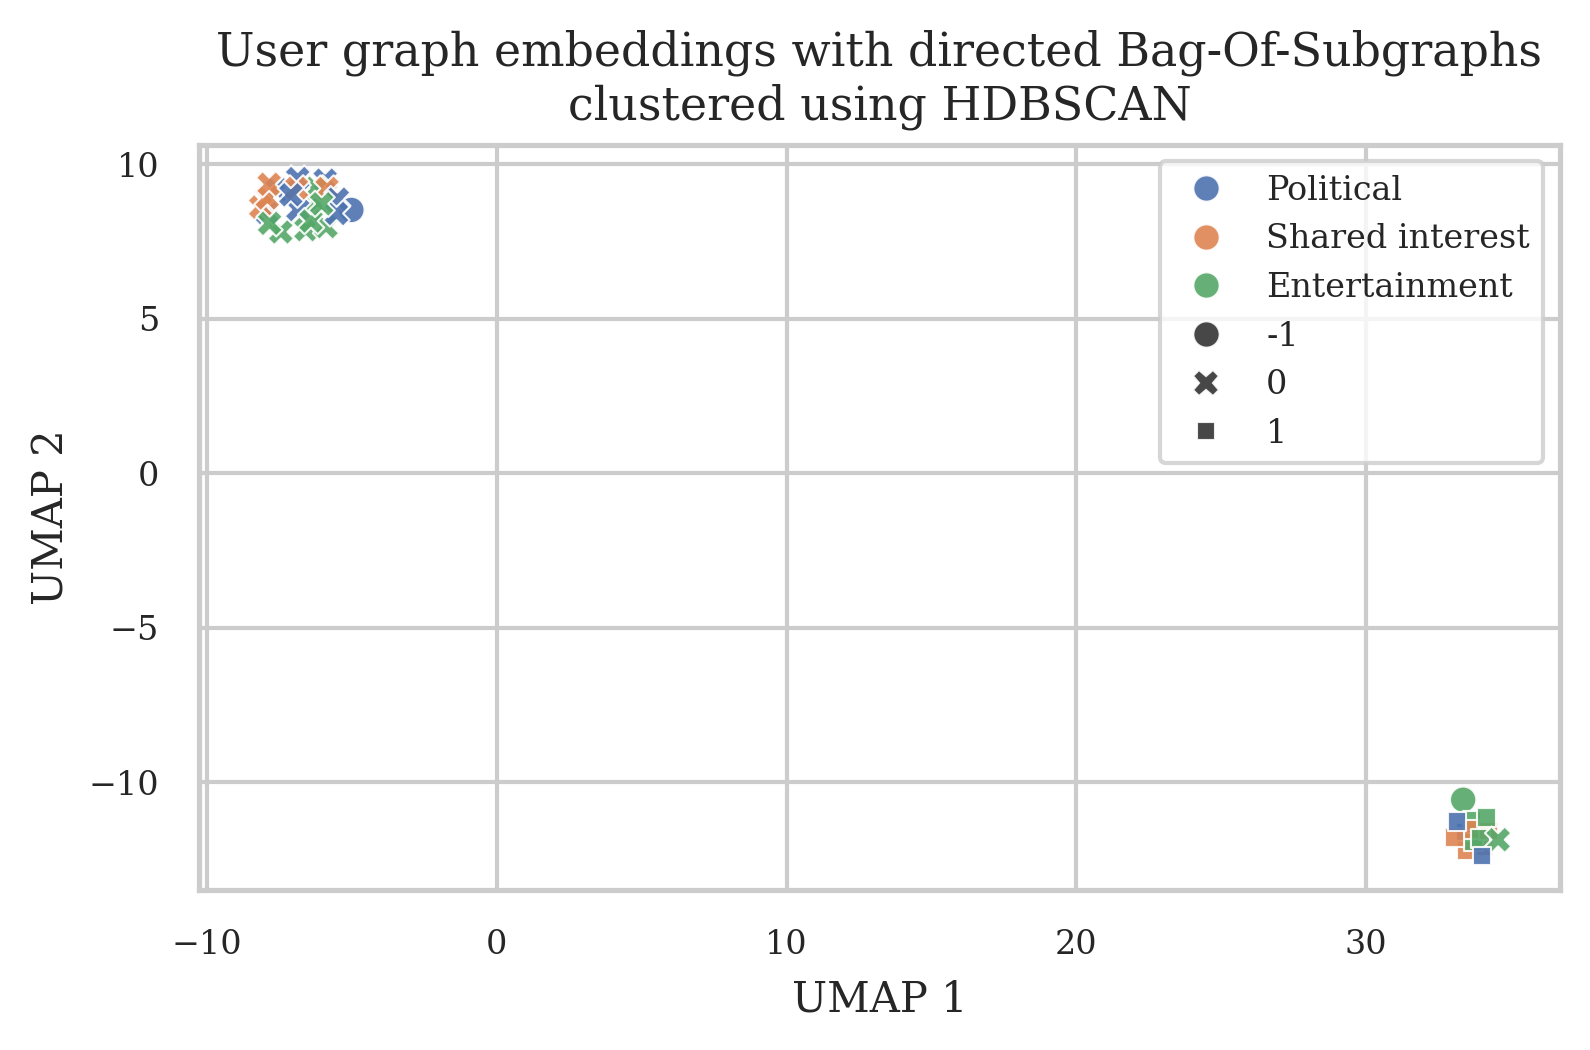

In [13]:
fig, ax = plt.subplots()
sns.scatterplot(x=dm_embs_umap[:, 0], y=dm_embs_umap[:, 1], hue=categories, style=dm_labels, s=40, alpha=0.9, ax=ax)
ax.set_title('User graph embeddings with directed Bag-Of-Subgraphs\nclustered using HDBSCAN')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/directed_subgraph.pgf', format='pgf', bbox_inches='tight')

### Sentiment Bag-Of-Subgraphs

In [14]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/sentiment_lcc.json'))

subgraph_data = [subgraph for subgraph in subgraph_data if 3 not in subgraph['edge_colors']]

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
sm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
sm_embs_pca = pca.fit_transform(sm_embs)
sm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(sm_embs)
print(pca.explained_variance_ratio_)

[0.75940558 0.07045146]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
hdbscan = HDBSCAN()
hdbscan.fit(sm_embs)
sm_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, sm_labels) if label != -1], 
    [label for label in sm_labels if label != -1])
num_no_cluster = len([label for label in sm_labels if label == -1])
print(nmi, num_no_cluster)

0.039324240836315145 2


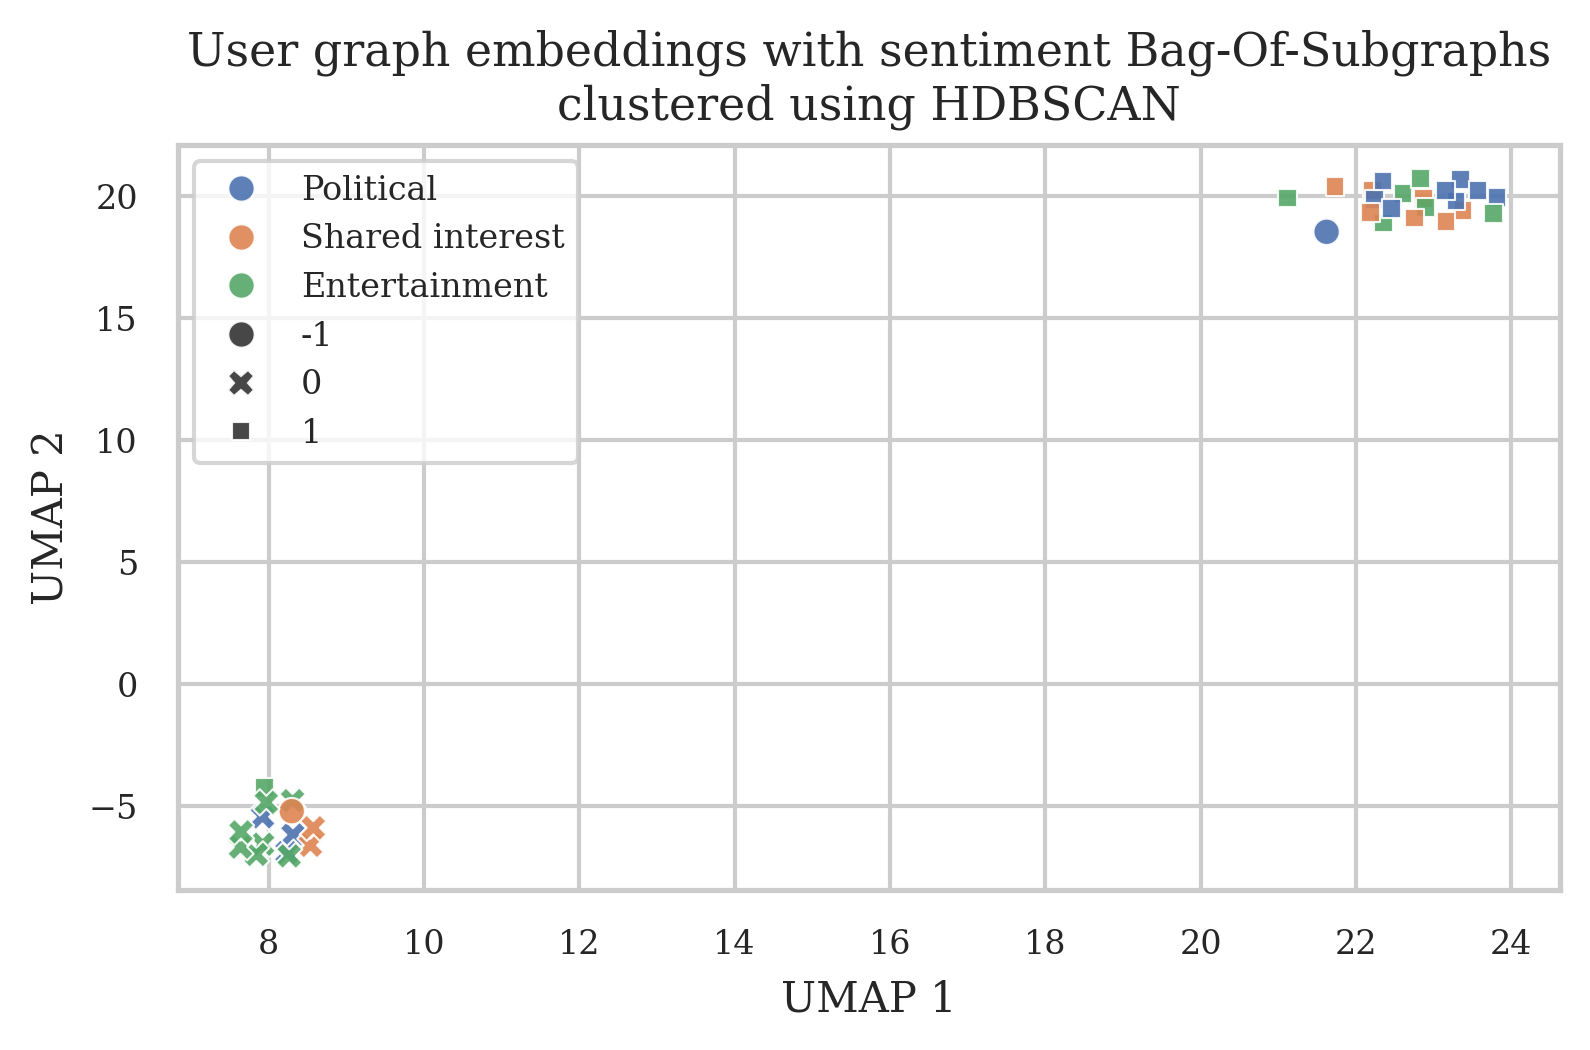

In [16]:
fig, ax = plt.subplots()
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, style=sm_labels, s=40, alpha=.9, ax=ax)
ax.set_title('User graph embeddings with sentiment Bag-Of-Subgraphs\nclustered using HDBSCAN')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/sentiment_subgraph.pgf', format='pgf', bbox_inches='tight')

### Directed sentiment Bag-Of-Subgraphs

In [17]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/sentiment_lcc_directed.json'))

subgraph_data = [subgraph for subgraph in subgraph_data if 3 not in subgraph['edge_colors']]

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
dsm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
dsm_embs_pca = pca.fit_transform(dsm_embs)
dsm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(dsm_embs)
print(pca.explained_variance_ratio_)

[0.65332423 0.08892003]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
hdbscan = HDBSCAN()
hdbscan.fit(dsm_embs)
dsm_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, dsm_labels) if label != -1], 
    [label for label in dsm_labels if label != -1])
num_no_cluster = len([label for label in dsm_labels if label == -1])
print(nmi, num_no_cluster)

0.023338093297950287 3


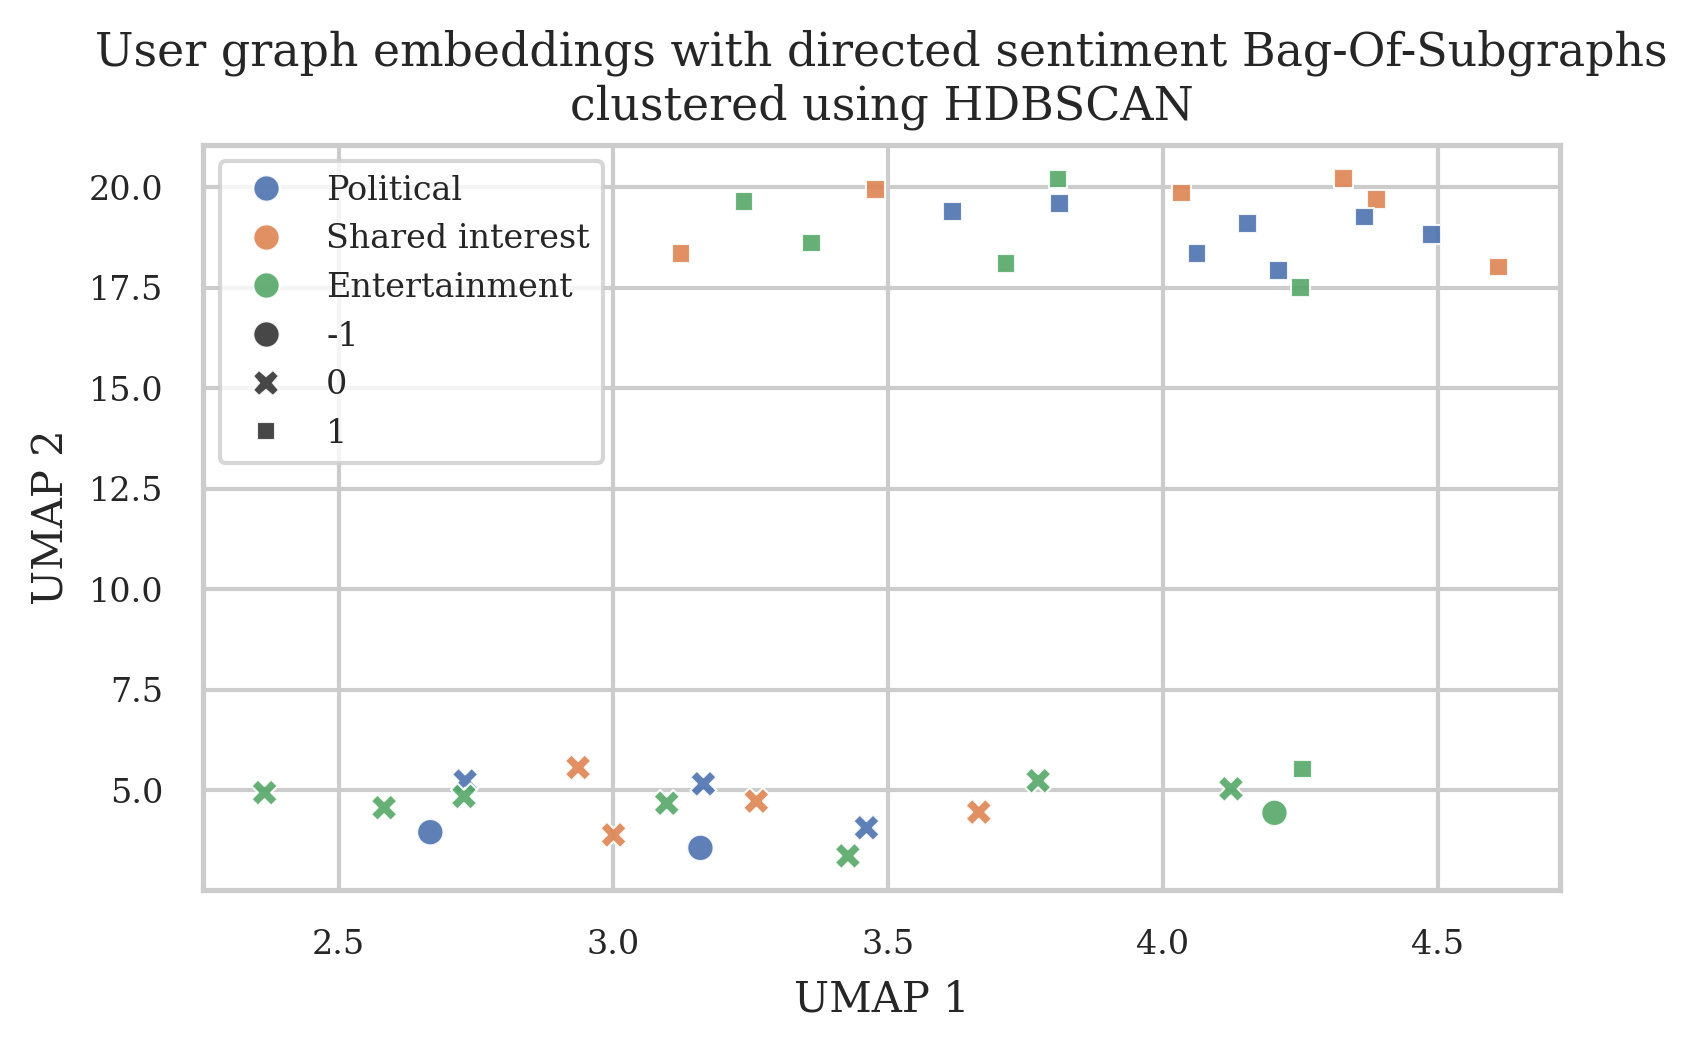

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(x=dsm_embs_umap[:, 0], y=dsm_embs_umap[:, 1], hue=categories, style=dsm_labels, s=40, alpha=.9, ax=ax)
ax.set_title('User graph embeddings with directed sentiment Bag-Of-Subgraphs\nclustered using HDBSCAN')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/sentiment_subgraph_directed.pgf', format='pgf', bbox_inches='tight')

### Super figure

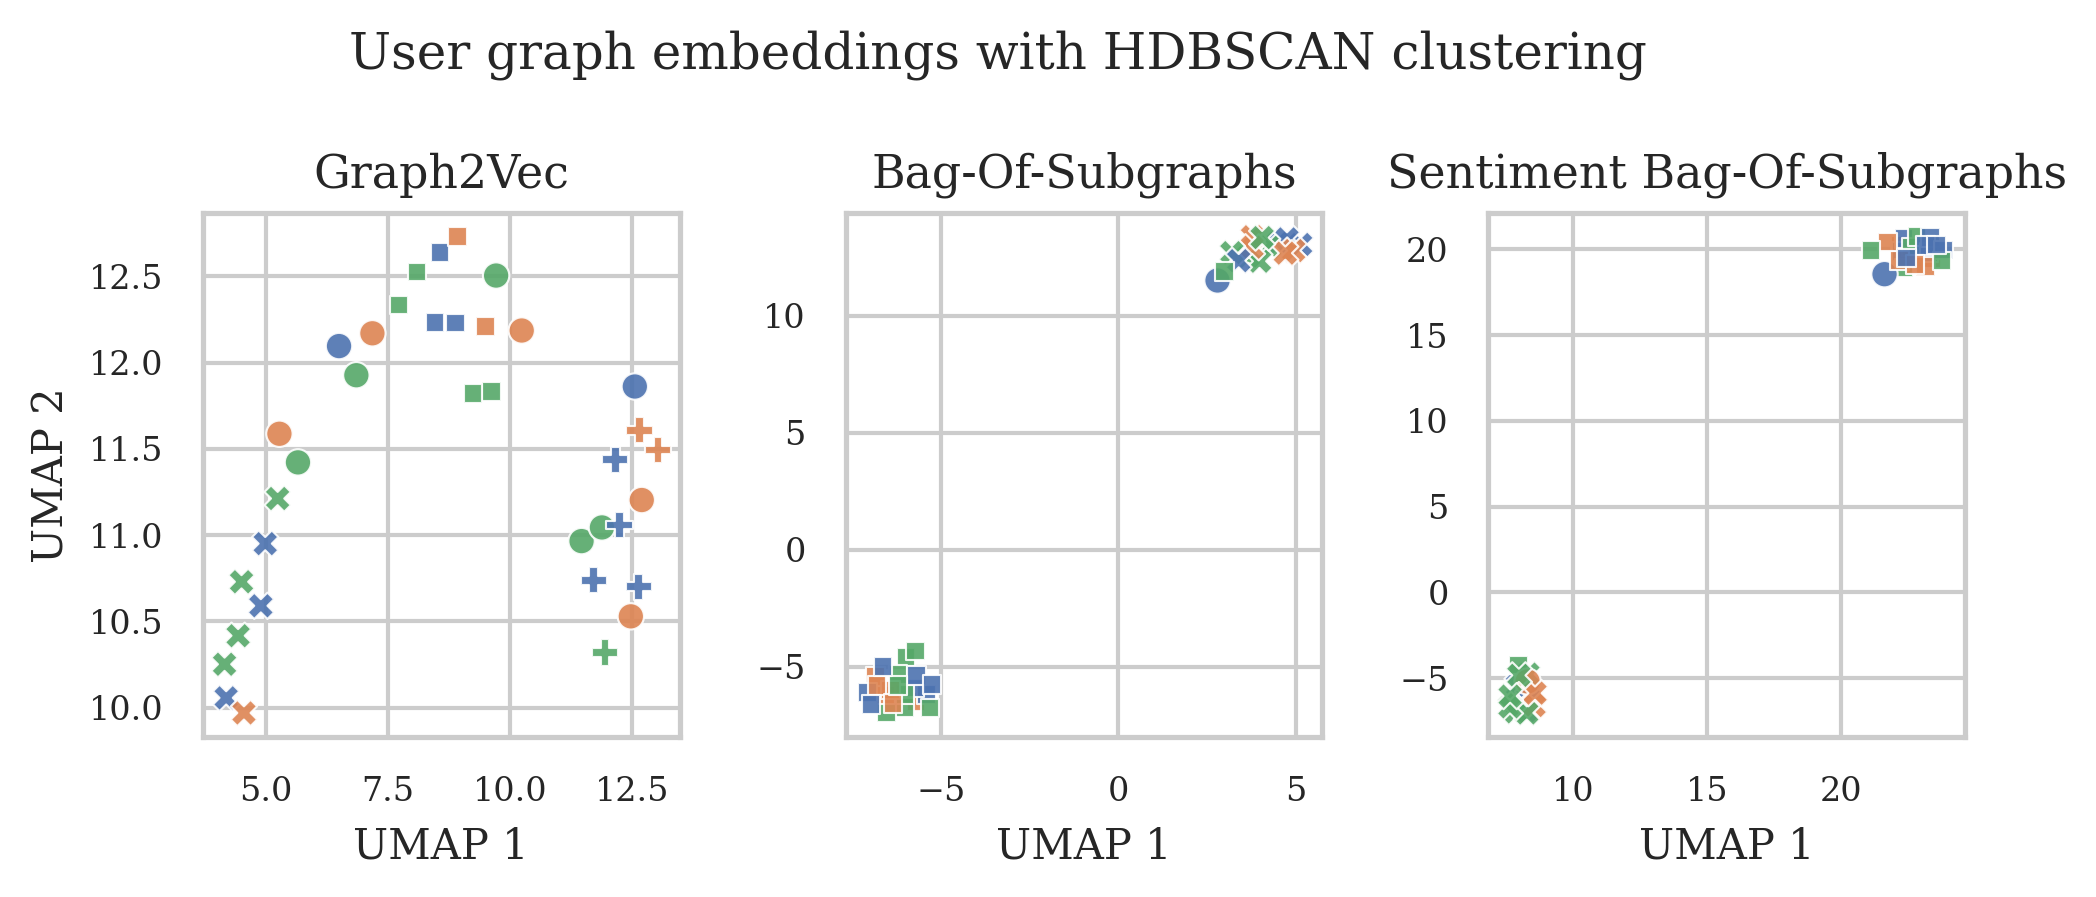

In [20]:
scale = 0.75
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6*scale*1.5, 4*scale))
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, style=g2v_labels, s=40, alpha=0.9, ax=ax1)
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, style=m_labels, s=40, alpha=0.9, legend=False, ax=ax2)
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, style=sm_labels, s=40, alpha=0.9, legend=False, ax=ax3)
fig.suptitle('User graph embeddings with HDBSCAN clustering')
ax1.set_title('Graph2Vec')
ax2.set_title('Bag-Of-Subgraphs')
ax3.set_title('Sentiment Bag-Of-Subgraphs')

ax1.set_ylabel('UMAP 2')
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('UMAP 1')
    
legend = ax1.get_legend()
ax1.legend_.remove()

plt.tight_layout()
plt.savefig('../figures/embeddings/embeddings_comparison.pgf', format='pgf', bbox_inches='tight')

(0.0, 1.0, 0.0, 1.0)

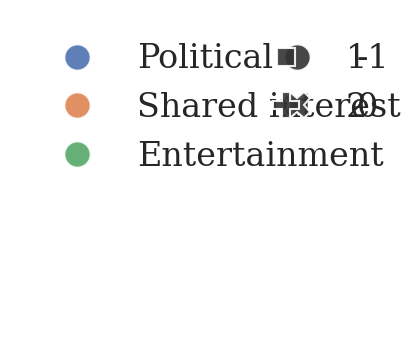

In [21]:
# https://gist.github.com/rldotai/012dbb3294bb2599ff82e61e82356990
fig.canvas.draw()
legend_bbox = legend.get_tightbbox(fig.canvas.get_renderer())
legend_bbox = legend_bbox.transformed(fig.dpi_scale_trans.inverted())

legend_fig, legend_ax = plt.subplots(figsize=(legend_bbox.width, legend_bbox.height))

legend_squared = legend_ax.legend(
    *ax1.get_legend_handles_labels(), 
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=legend_fig.transFigure,
    frameon=False,
    fancybox=None,
    shadow=False,
    ncol=3,
    mode='expand',
)

legend_ax.axis('off')
# plt.savefig('../figures/embeddings/legend.pgf', format='pgf', bbox_inches='tight')

### FeatherGraph

In [22]:
model = FeatherGraph()
model.fit(graphs_nx)
fg_embs = model.get_embedding()
pca = PCA(n_components=2)
fg_embs_pca = pca.fit_transform(fg_embs)
fg_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(fg_embs)
print(pca.explained_variance_ratio_)

[0.38161885 0.27791998]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
hdbscan = HDBSCAN(alpha=0.5)
hdbscan.fit(fg_embs)
fg_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, fg_labels) if label != -1], 
    [label for label in fg_labels if label != -1])
num_no_cluster = len([label for label in fg_labels if label == -1])
print(nmi, num_no_cluster)

0.19477329309254146 17


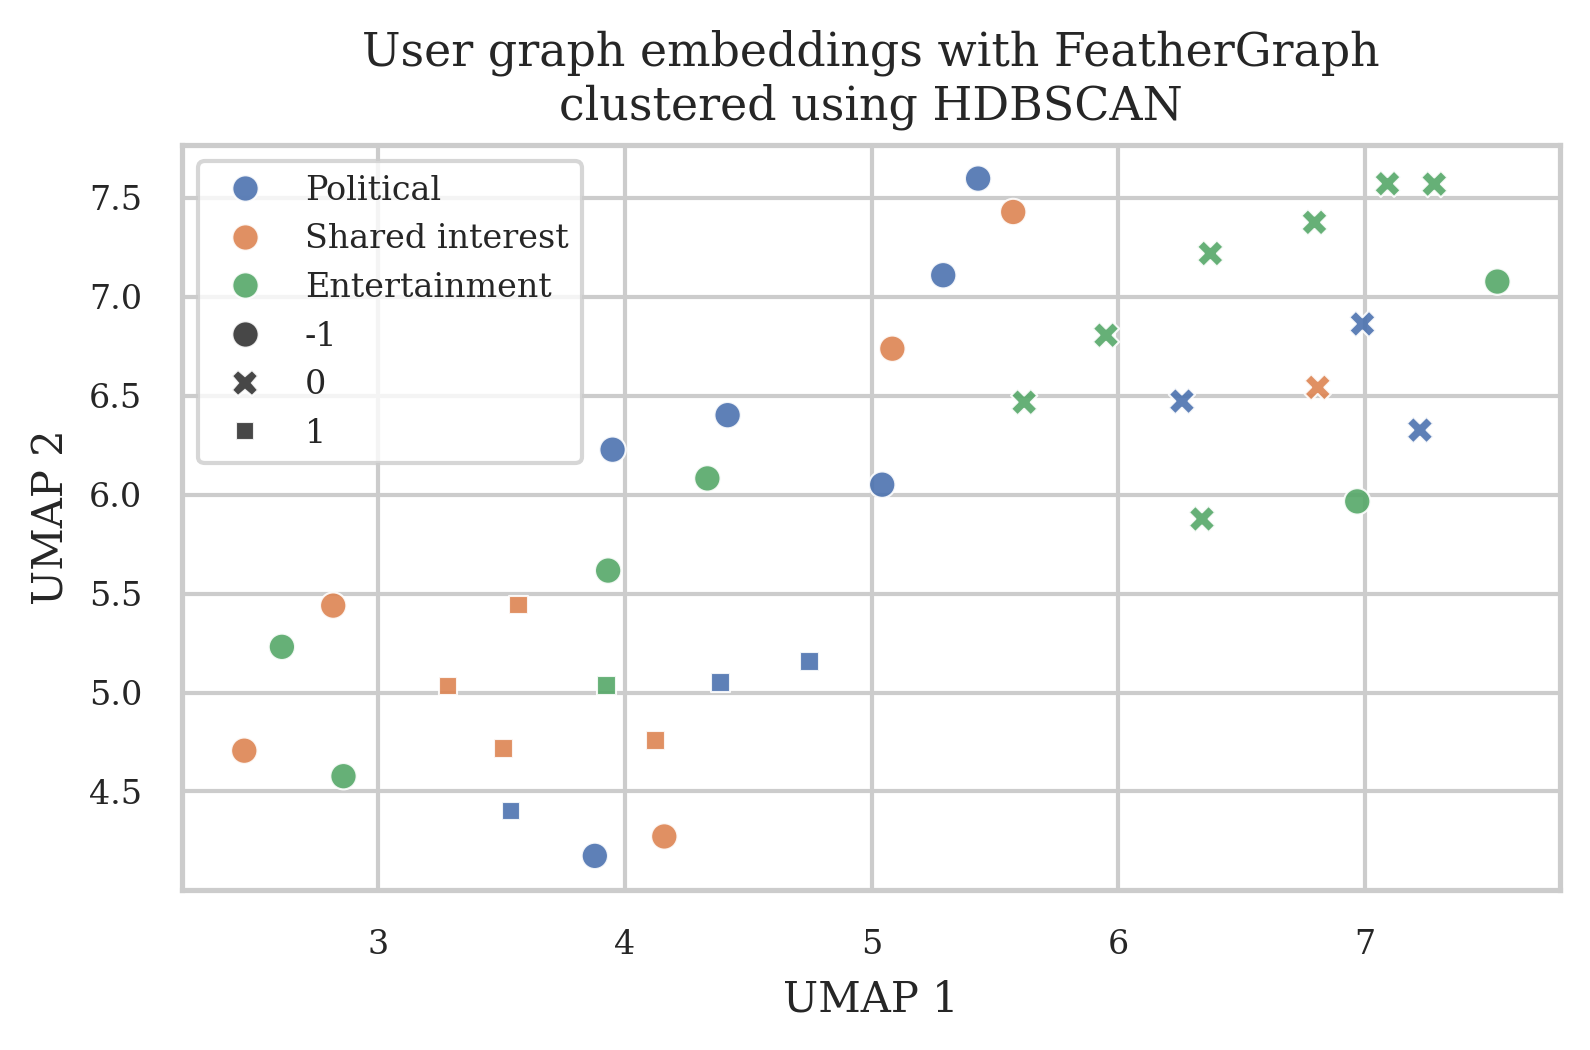

In [24]:
fig, ax = plt.subplots()
sns.scatterplot(x=fg_embs_umap[:, 0], y=fg_embs_umap[:, 1], hue=categories, style=fg_labels, s=40, alpha=.9, ax=ax)
ax.set_title('User graph embeddings with FeatherGraph\nclustered using HDBSCAN')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/feathergraph.pgf', format='pgf', bbox_inches='tight')

# Twitter magic

In [25]:
tiktok = get_all_sentiment_user_graphs()
twitter = get_all_twitter_user_graphs()
graphs = tiktok + twitter
graphs = [g.components(mode='weak').giant() for g in graphs]
graphs_nx = [g.simplify().to_networkx() for g in graphs]

categories = len(tiktok) * ['TikTok'] + len(twitter) * ['Twitter']
names = [g['name'] for g in graphs]

In [26]:
model = Graph2Vec(workers=1, seed=42)
model.fit(graphs_nx)
g2v_embs = model.get_embedding()
pca = PCA(n_components=2)
g2v_embs_pca = pca.fit_transform(g2v_embs)
g2v_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(g2v_embs)
print(pca.explained_variance_ratio_)

[0.7217796  0.13443492]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


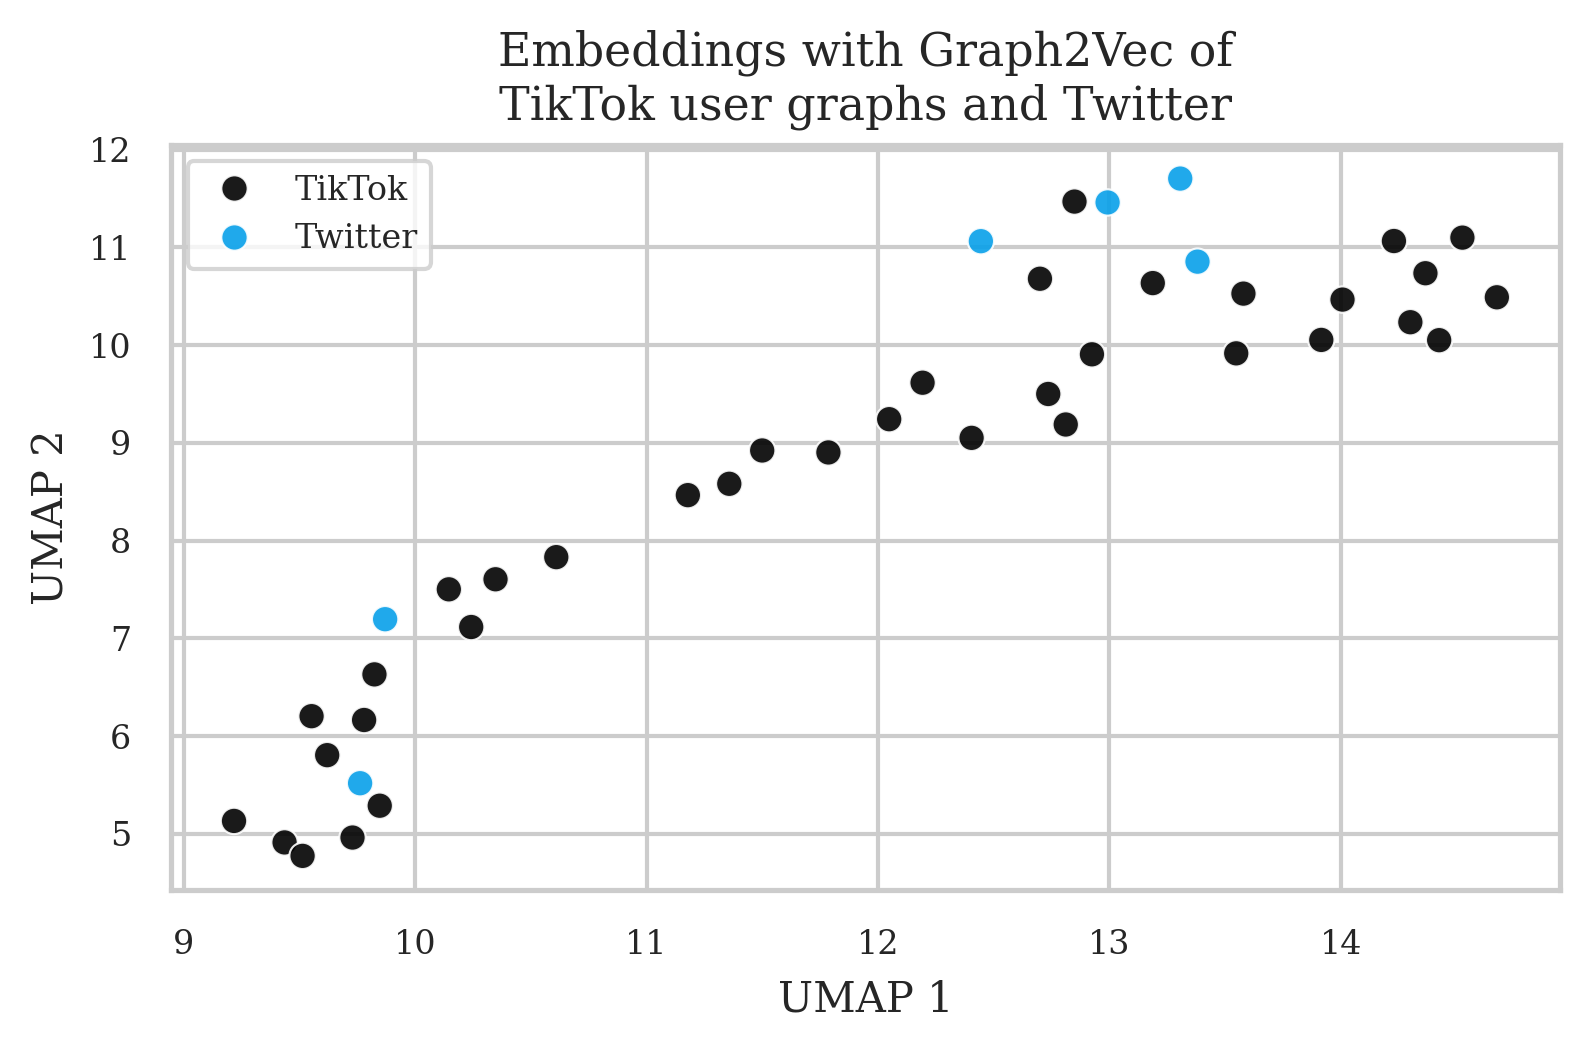

In [27]:
fig, ax = plt.subplots()
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'],s=40, alpha=0.9, ax=ax)
ax.set_title('Embeddings with Graph2Vec of\nTikTok user graphs and Twitter')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()

In [28]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/lcc.json'))

# extract motif matrix
subgraph_matrix = np.concatenate((
    [subgraph['graph_occurrences'] for subgraph in subgraph_data],
    [subgraph['twitter_occurences'] for subgraph in subgraph_data]
), axis=1)
m_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
m_embs_pca = pca.fit_transform(m_embs)
m_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(m_embs)
print(pca.explained_variance_ratio_)

[0.79089999 0.07149393]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


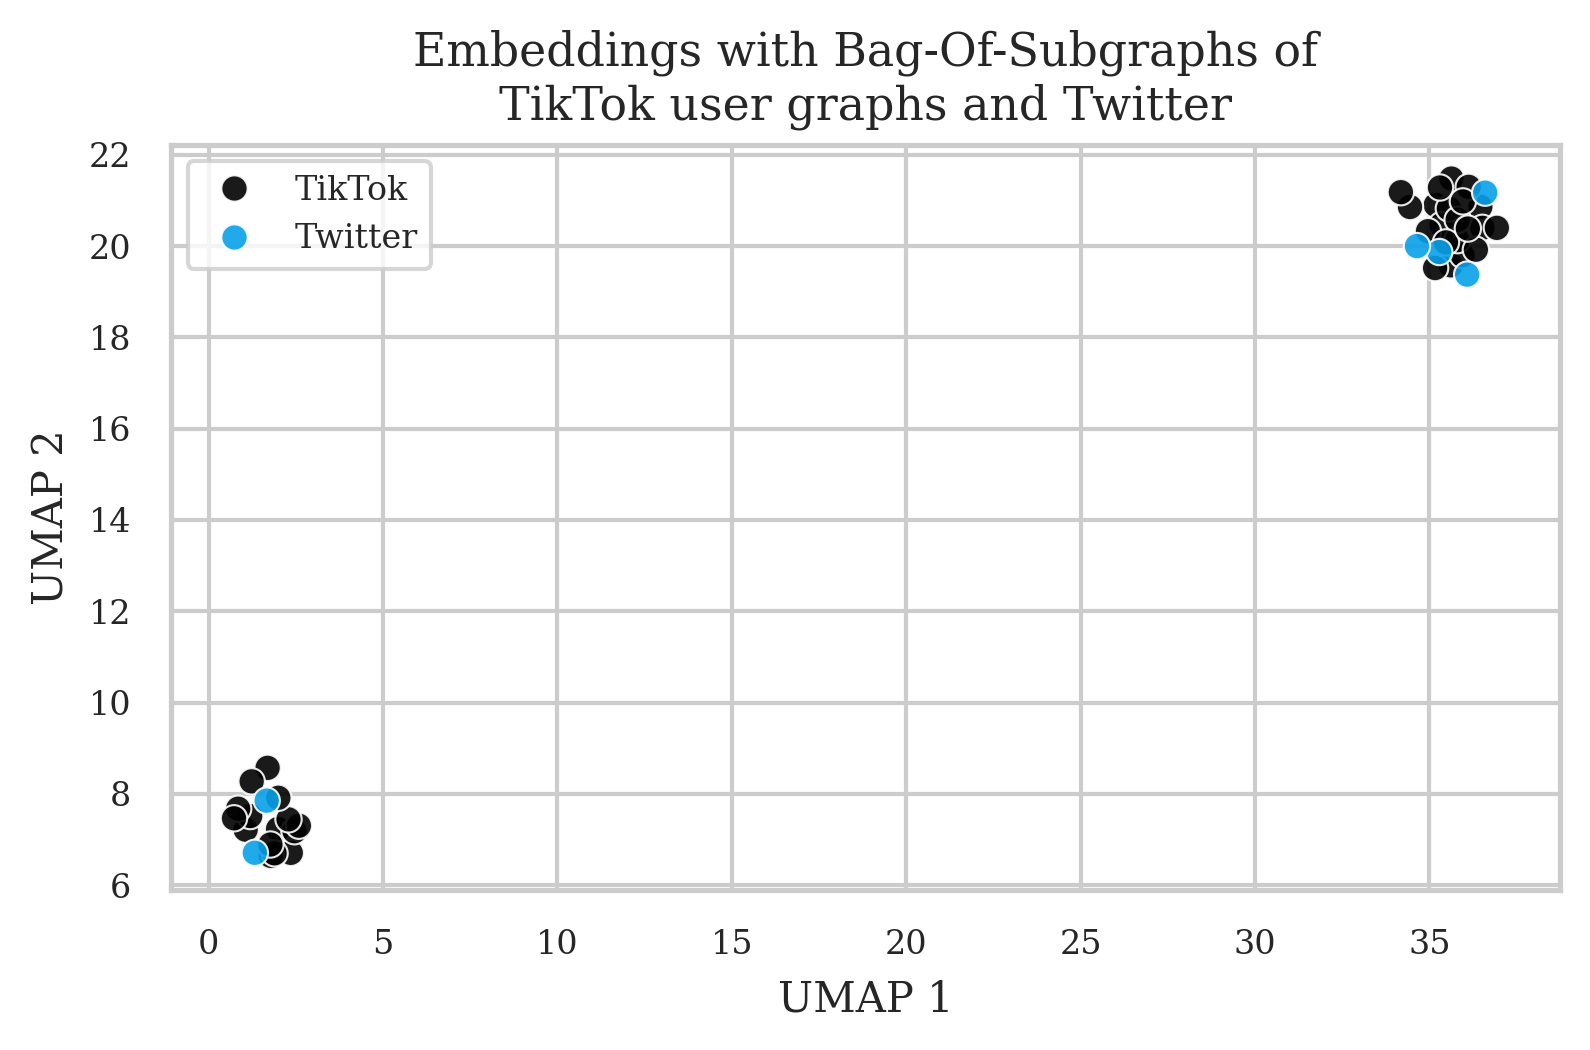

In [29]:
fig, ax = plt.subplots()
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'],s=40, alpha=0.9, ax=ax)
ax.set_title('Embeddings with Bag-Of-Subgraphs of\nTikTok user graphs and Twitter')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()

In [30]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/sentiment_lcc.json'))

# remove missing content subgraphs
subgraph_data = [subgraph for subgraph in subgraph_data if 3 not in subgraph['edge_colors']]

# extract motif matrix
subgraph_matrix = np.concatenate((
    [subgraph['graph_occurrences'] for subgraph in subgraph_data],
    [subgraph['twitter_occurences'] for subgraph in subgraph_data]
), axis=1)
sm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
sm_embs_pca = pca.fit_transform(sm_embs)
sm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(sm_embs)
print(pca.explained_variance_ratio_)

[0.76977807 0.06452051]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


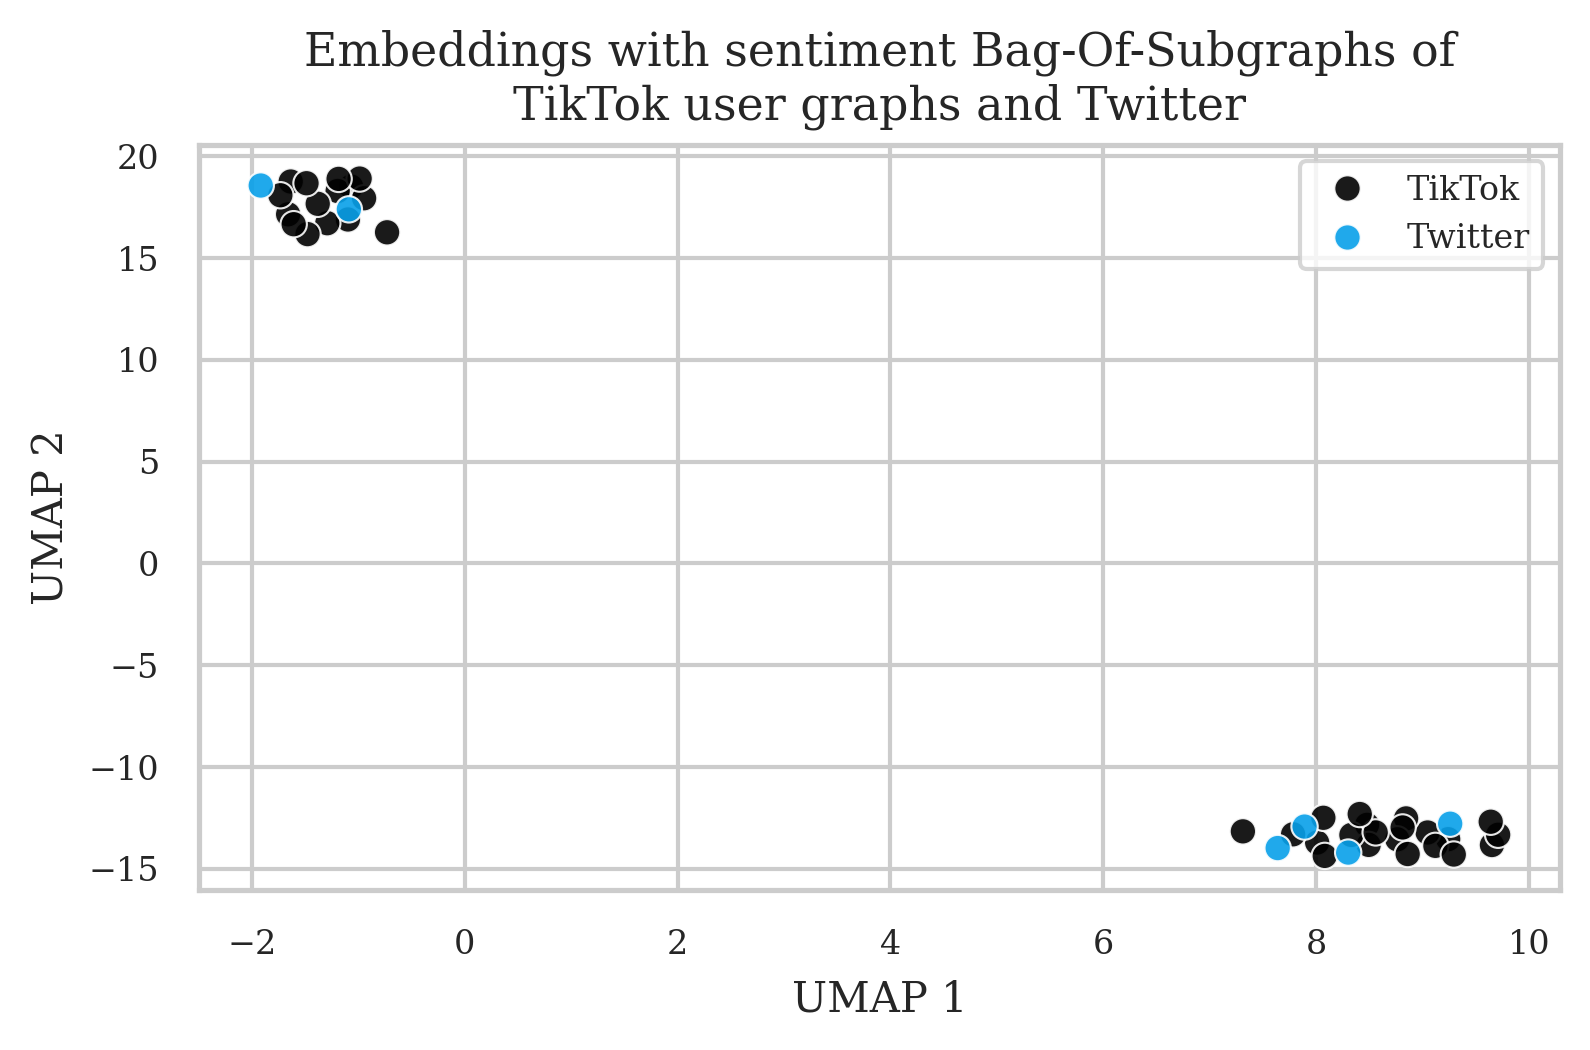

In [31]:
fig, ax = plt.subplots()
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'],s=40, alpha=0.9, ax=ax)
ax.set_title('Embeddings with sentiment Bag-Of-Subgraphs of\nTikTok user graphs and Twitter')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()

In [32]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/sentiment_lcc_directed.json'))

# remove missing content subgraphs
subgraph_data = [subgraph for subgraph in subgraph_data if 3 not in subgraph['edge_colors']]

# extract motif matrix
subgraph_matrix = np.concatenate((
    [subgraph['graph_occurrences'] for subgraph in subgraph_data],
    [subgraph['twitter_occurences'] for subgraph in subgraph_data]
), axis=1)
dsm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
dsm_embs_pca = pca.fit_transform(dsm_embs)
dsm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(dsm_embs)
print(pca.explained_variance_ratio_)

[0.68312971 0.0768817 ]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


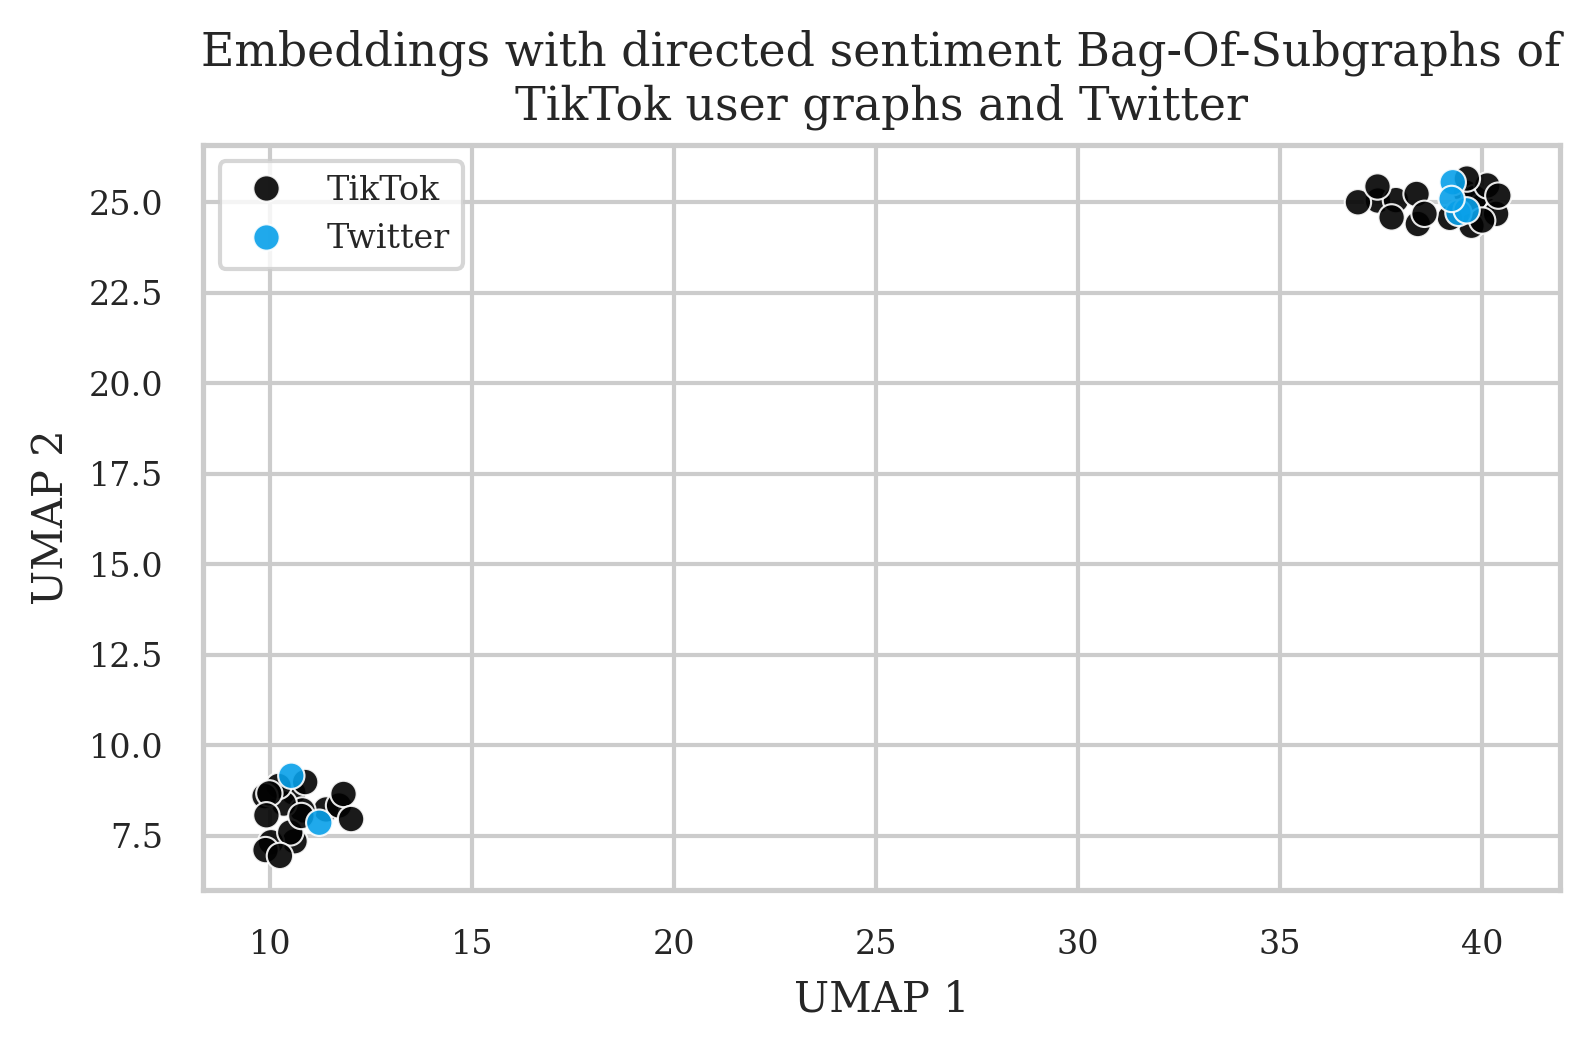

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(x=dsm_embs_umap[:, 0], y=dsm_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'],s=40, alpha=0.9, ax=ax)
ax.set_title('Embeddings with directed sentiment Bag-Of-Subgraphs of\nTikTok user graphs and Twitter')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()

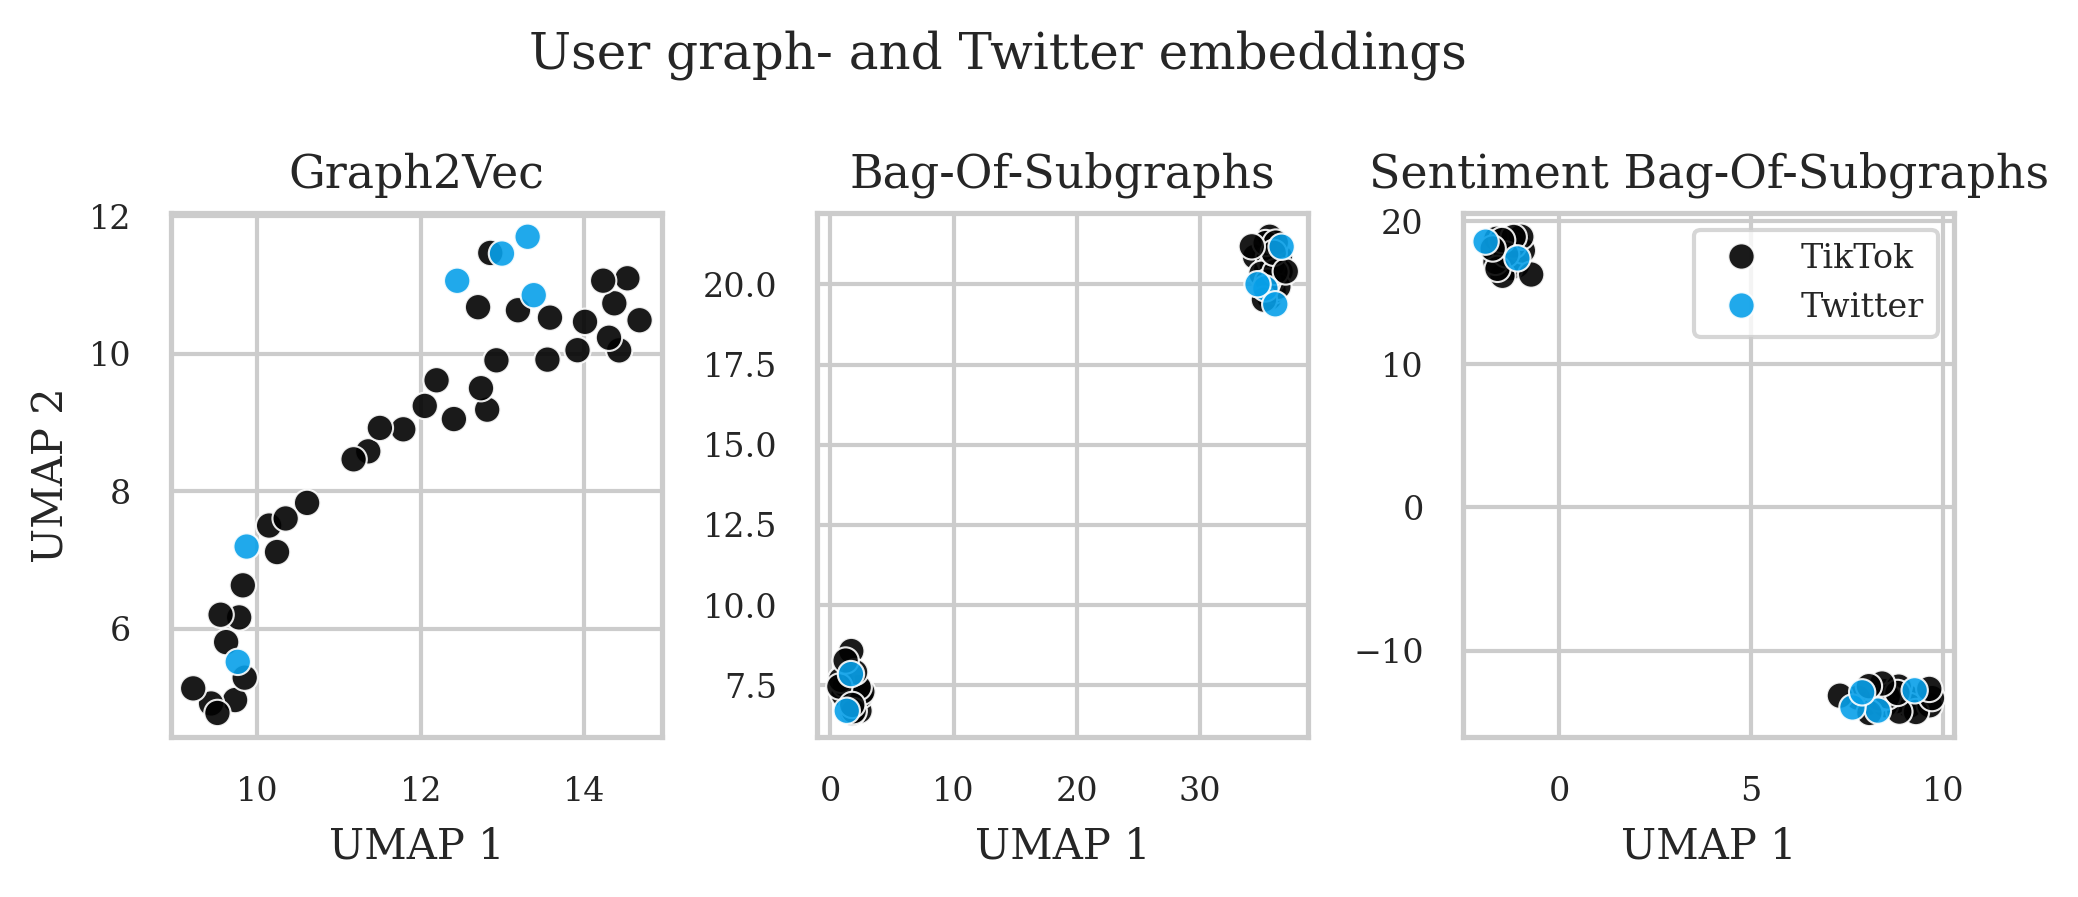

In [34]:
scale = 0.75
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6*scale*1.5, 4*scale))
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'], s=40, alpha=0.9, legend=False, ax=ax1)
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'], s=40, alpha=0.9, legend=False, ax=ax2)
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'], s=40, alpha=0.9, ax=ax3)
fig.suptitle('User graph- and Twitter embeddings')
ax1.set_title('Graph2Vec')
ax2.set_title('Bag-Of-Subgraphs')
ax3.set_title('Sentiment Bag-Of-Subgraphs')

ax1.set_ylabel('UMAP 2')
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('UMAP 1')

plt.tight_layout()
plt.savefig('../figures/embeddings/twitter_comparison.pgf', format='pgf', bbox_inches='tight')